In [68]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

from ga import rand_nodup, not_dup
from util import pickle_load
from util import robust_z 
                                                             
import random
from deap import base, creator, tools, algorithms
from statistics import variance
from scipy.stats import norm
import pandas as pd
import numpy as np
import time
import itertools
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw,AllChem
import umap

In [69]:
# validation test name
test_num = "1001"
lig = "!"

In [70]:
date = 240702
num = 1
trys = str(date) + "_" + str(num)

In [71]:
if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 

In [72]:
all_smiles = []
for i in range(len(cas_tox)):
    all_smiles.append(cas_tox.iloc[i,2])

molecules = [Chem.MolFromSmiles(smiles) for smiles in all_smiles]

In [73]:
fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

In [74]:
pops = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/top_5.tsv", sep="\t", header=None)

In [75]:
def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    toxicity_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "discrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        mean = len(individual) / 2
        std_dev = len(individual) / 10
        toxicity_score = norm.pdf(x=count_t, loc=mean, scale=std_dev) * 1000

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]

        structure = dict_t[0]
        phisical = dict_t[1]

        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [76]:
best_pop = pops.iloc[-1,0]
tox_scoring = "continuous"

IND_INIT_SIZE = len(val)

all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "discrete":
    standardized_toxs = all_toxs

best_pop = best_pop.replace("Individual(", "").replace(")", "")
best_pop = list(ast.literal_eval(best_pop))
best_score = multi_objective_optimization(best_pop)

color = []
for i in range(len(cas_tox)):
    if i in best_pop:
        color.append("red")
    else:
        color.append("blue")

(5.326183372073294, 39.38873862397955, 0.6744897501960817)


/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


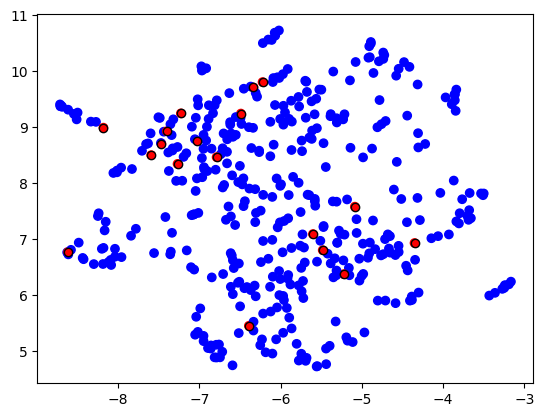

In [77]:
print(best_score)
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(fp)
embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]
plt.scatter(embedding_x, embedding_y, c=color, linewidths=1)
plt.scatter([embedding_x[i] for i in best_pop],  [embedding_y[i] for i in best_pop], c='red', ec='black', linewidth=1)
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/UMAP_[-1,0].png")
plt.show()